In [155]:
# KÜTÜPHANE EKLEME

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr
from tabulate import tabulate
from sklearn.model_selection import train_test_split

# Tüm uyarıları gizle
import warnings
warnings.filterwarnings("ignore")

In [157]:
# VERİ SETİ YÜKLEME

df = pd.read_csv('water_potability.csv')

# Veri seriyle ilgili bilgilerin alınması

def df_info(dataframe, head=5):
    print("#################### SHAPE ####################")
    print(dataframe.shape)
    print("#################### TYPES ####################")
    print(dataframe.dtypes)
    print("#################### HEAD ####################")
    print(dataframe.head(head))
    print("#################### TAIL ####################")
    print(dataframe.tail(head))
    print("#################### NA ####################")  # MISSING VALUES VAR MI ?
    print(dataframe.isnull().sum())
    print("#################### QUANTILES ####################") # SAYISAL DEĞİŞKENLİK DEĞİŞKENLERİ
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

df_info(df)


df.describe() # COUNT, MEAN, STD, MIN/MAX, ÇEYREKLİK DEĞERLER

#################### SHAPE ####################
(3276, 10)
#################### TYPES ####################
ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object
#################### HEAD ####################
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783    

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

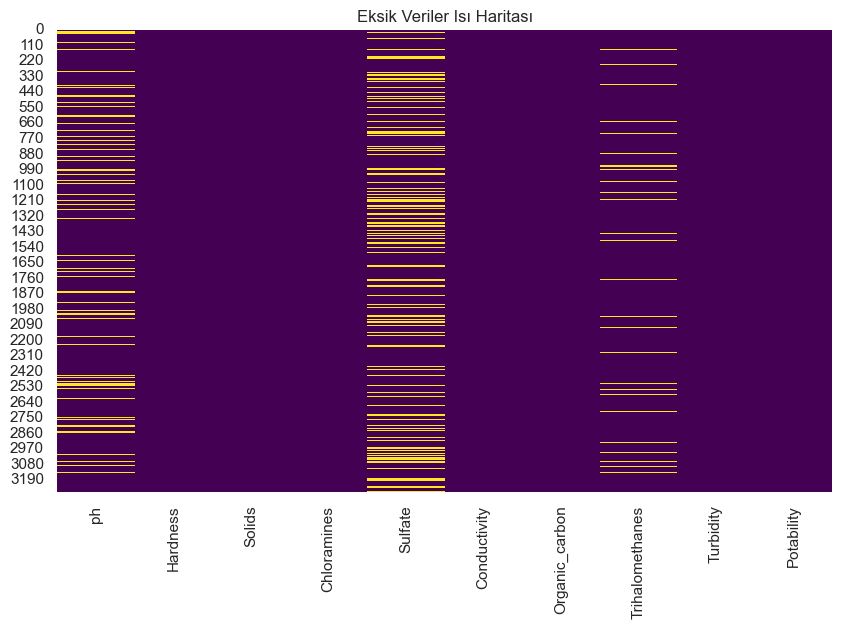

In [159]:
# VERİ SETİ GÖRSELLEŞTİRMESİ 

# ISI HARİTASI
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar= False, cmap="viridis")
plt.title("Eksik Veriler Isı Haritası")
plt.show()


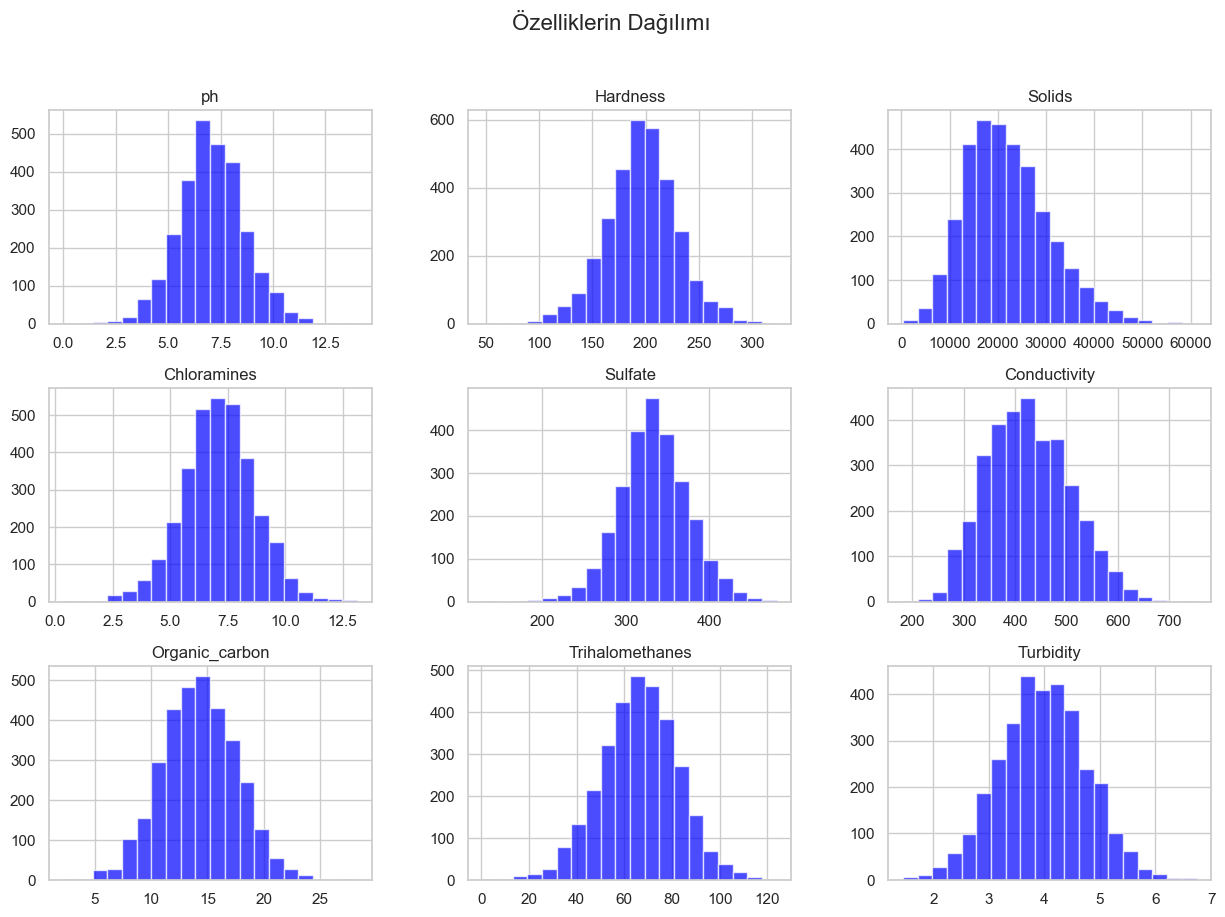

In [161]:
# VERİ SETİ GÖRSELLEŞTİRMESİ 

# HİSTOGRAM GRAFİĞİ
df.drop(columns=["Potability"]).hist(figsize=(15,10), bins=20, color="blue", alpha=0.7)
plt.suptitle("Özelliklerin Dağılımı", fontsize=16)
plt.show()

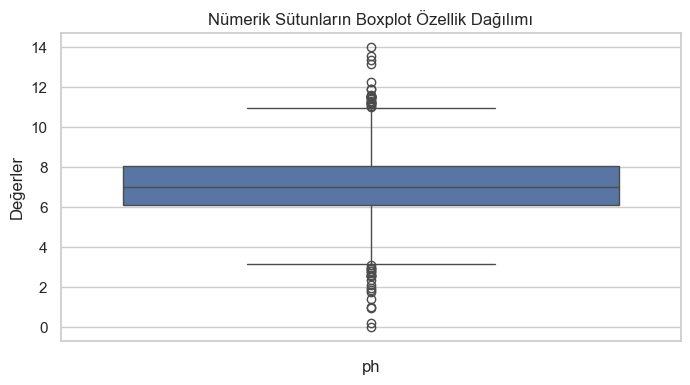

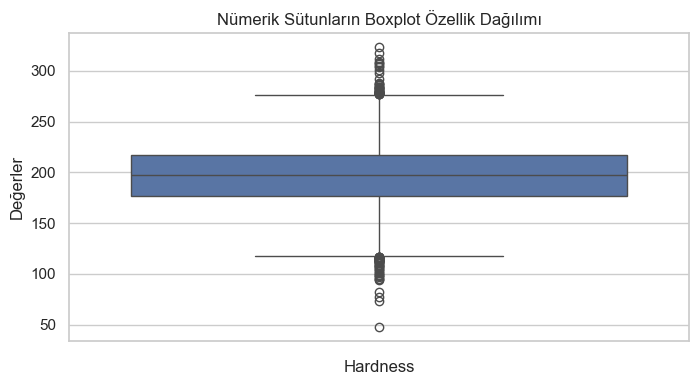

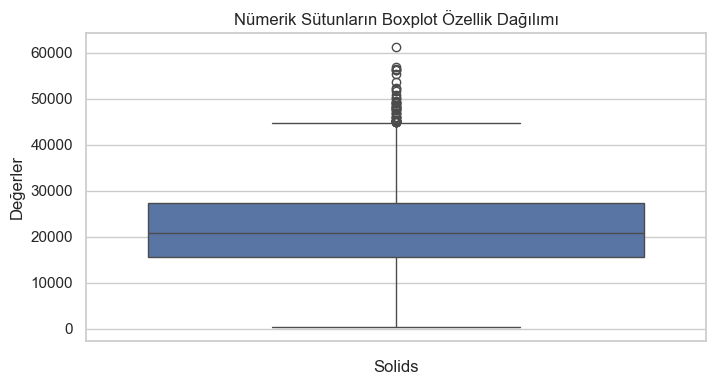

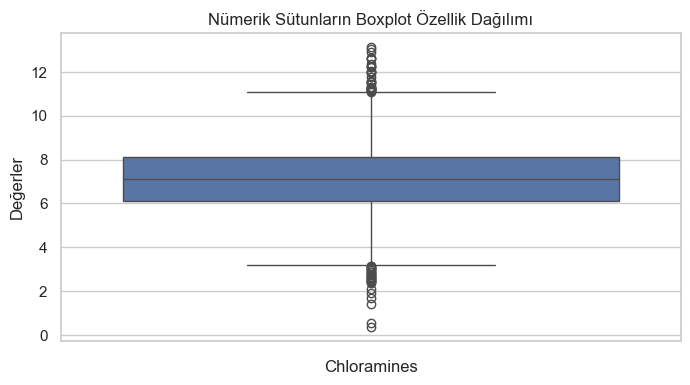

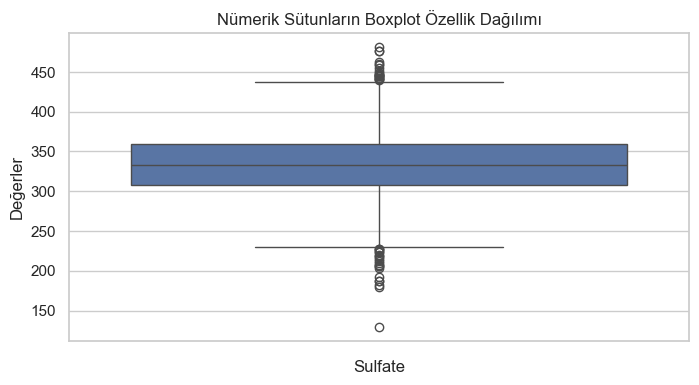

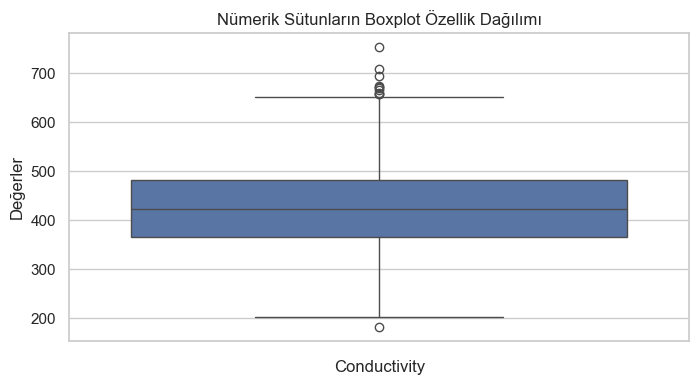

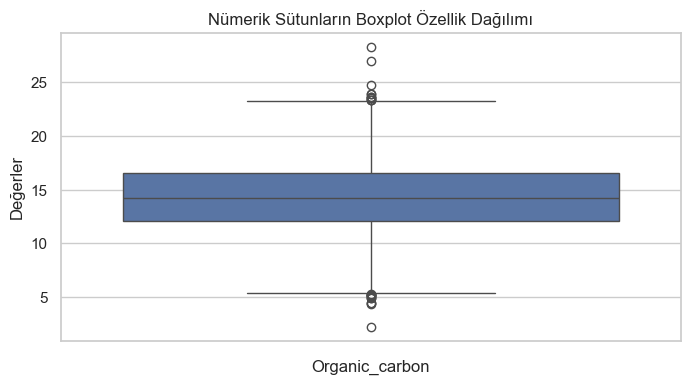

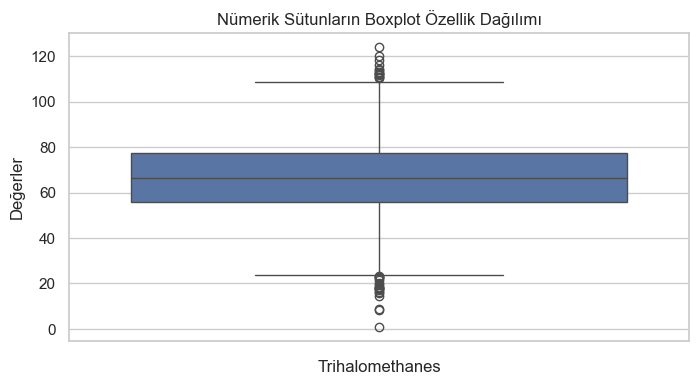

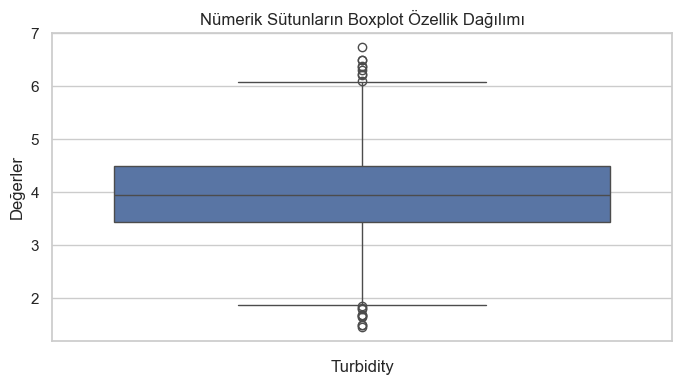

In [162]:
# VERİ SETİ GÖRSELLEŞTİRMESİ 

# BOXPLOT
def boxplot_df(dataframe):
    col_name = df.columns[-1]
    df_new = dataframe.drop(labels=col_name, axis=1)
    for column in df_new.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(data=dataframe[column])
        plt.title("Nümerik Sütunların Boxplot Özellik Dağılımı")
        plt.xlabel(column)
        plt.ylabel("Değerler")
        plt.show()

boxplot_df(df)

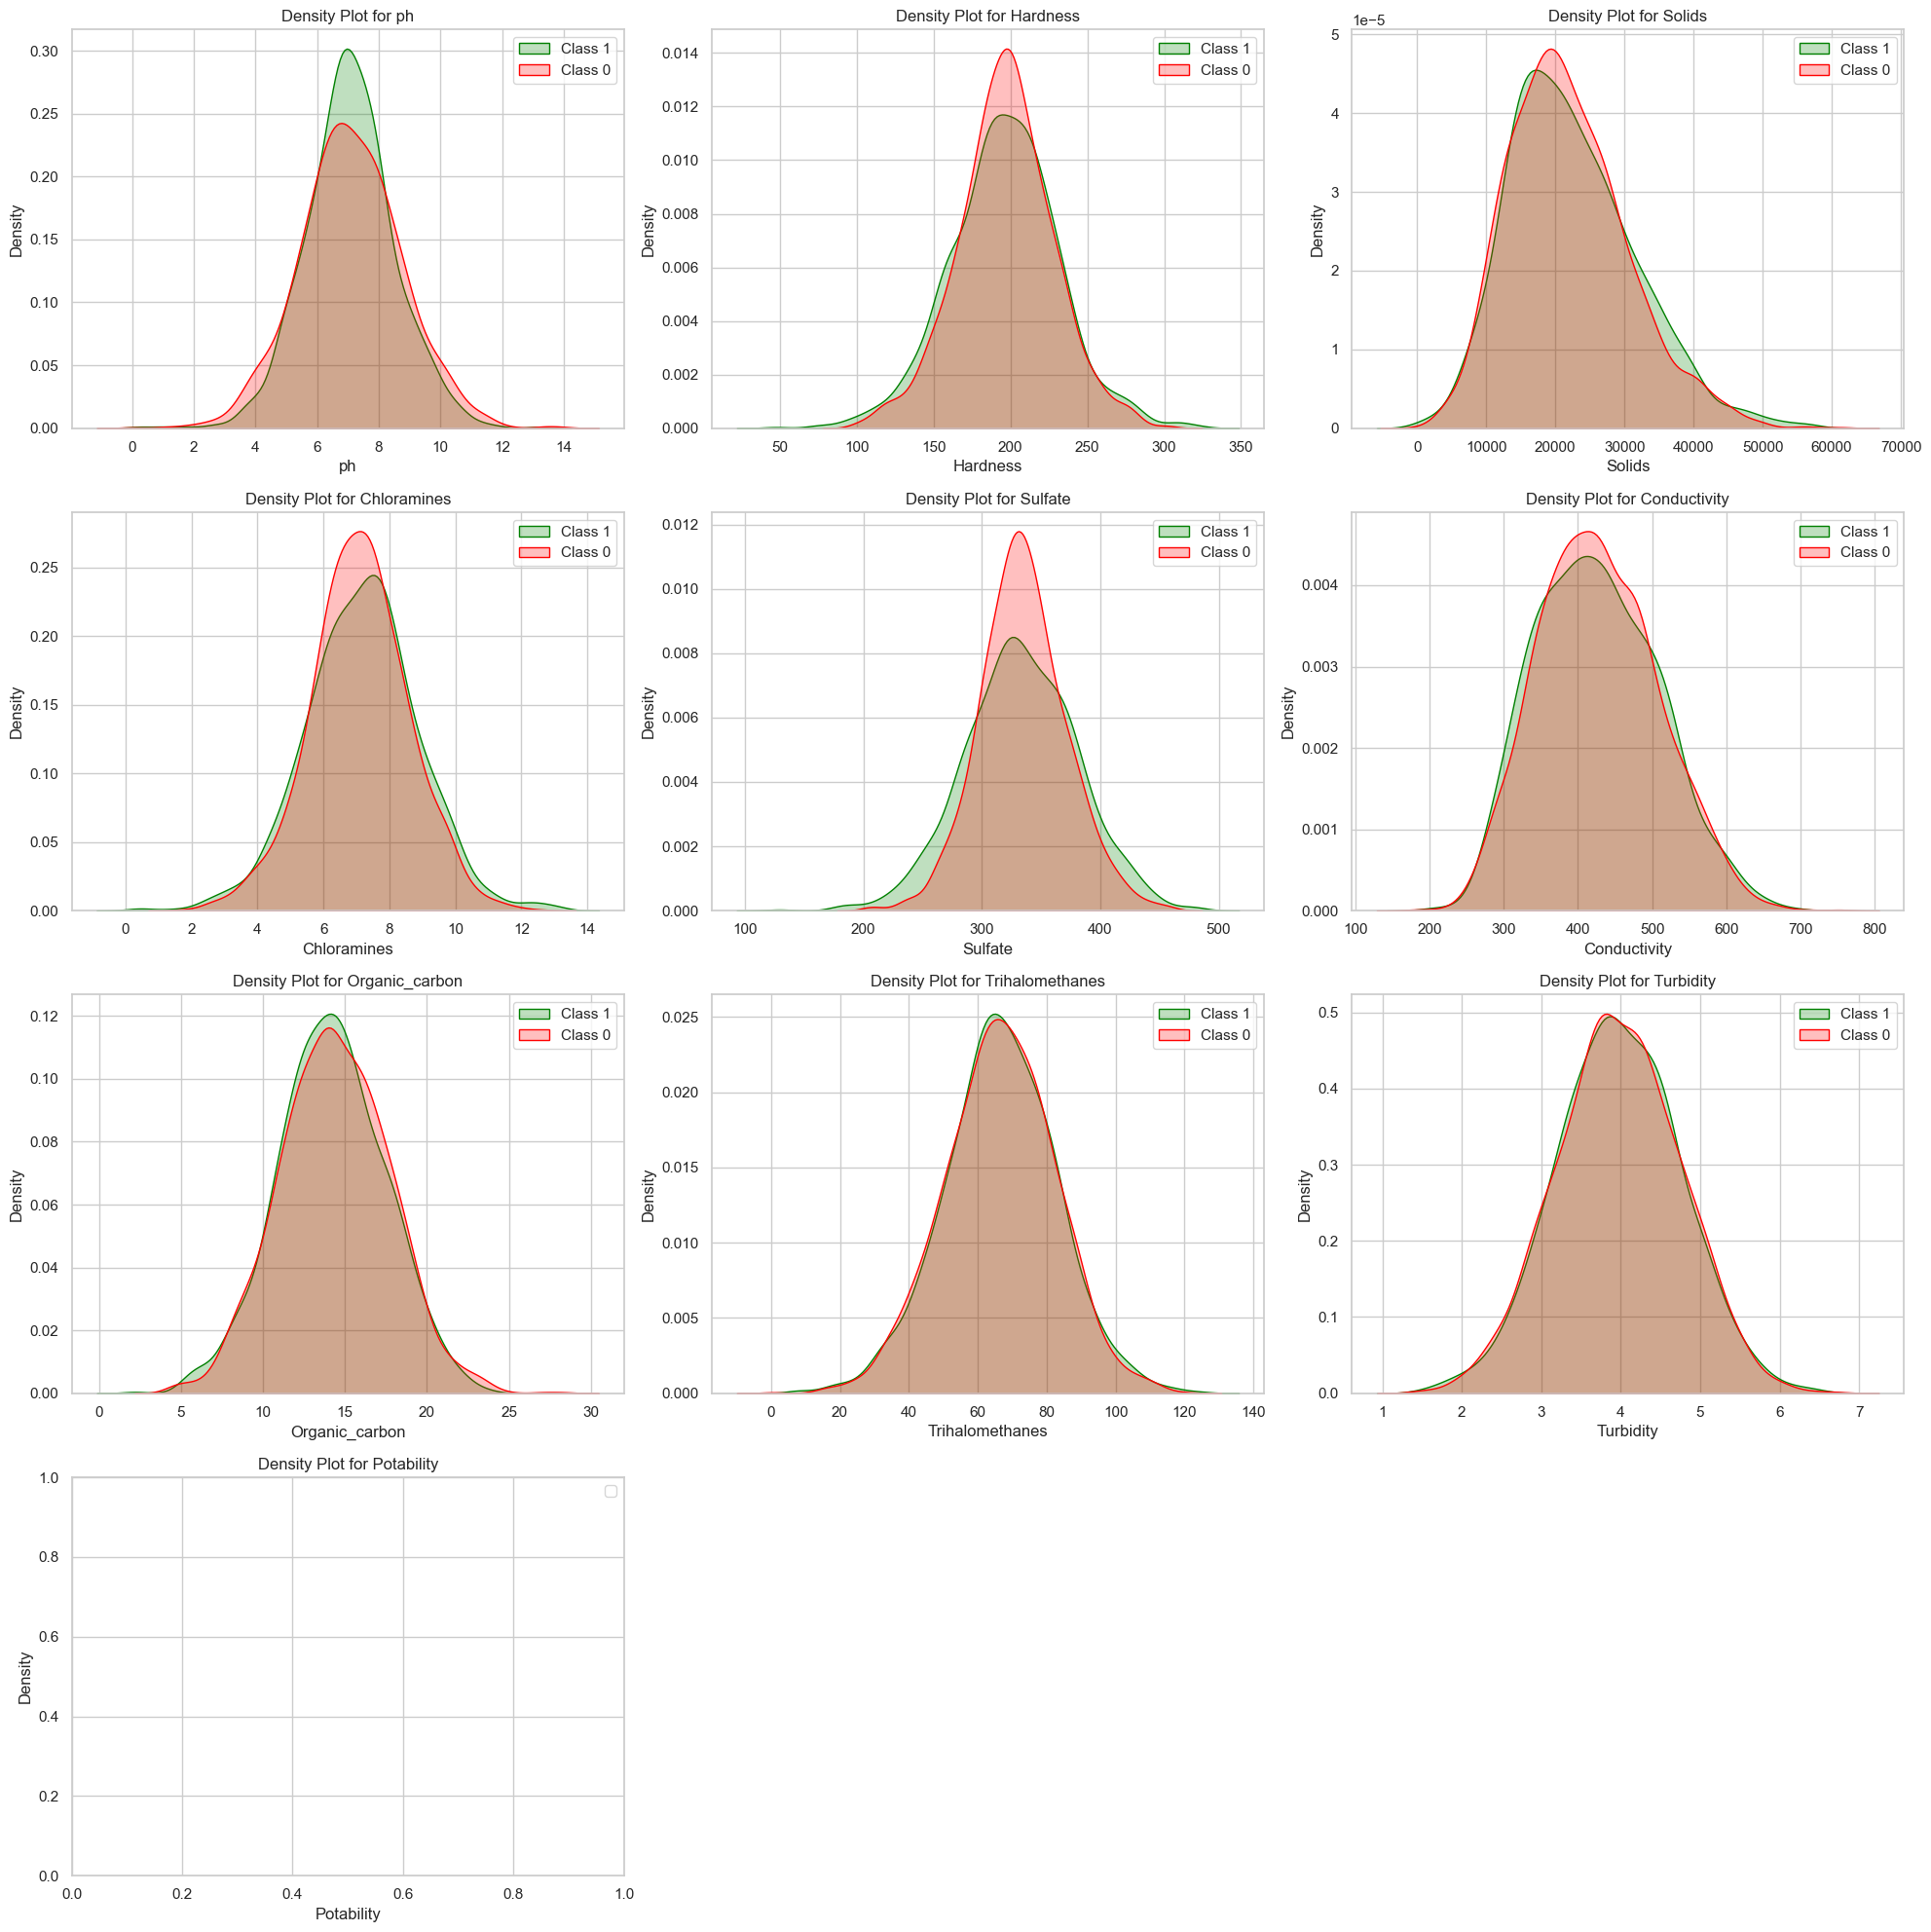

In [164]:
# VERİ SETİ GÖRSELLEŞTİRMESİ 

# KERNEL DENSITY ESTIMATION (KDE) PLOT
def target_density_est_with_num_subplot(dataframe, target, numerical_cols):
    # Subplot düzeni
    n_cols = 3  # Her satırda 3 grafik
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # Satır sayısını
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))  # Subplotlar için genel boyut
    axes = axes.flatten()  # Subplotları listeye dönüştürme
    
    # Grafiklerin oluşturulması
    for i, col in enumerate(numerical_cols):
        ax = axes[i]  # İlgili subplot ekseni
        sns.kdeplot(dataframe[col][dataframe[target] == 1], color="green", shade=True, ax=ax)
        sns.kdeplot(dataframe[col][dataframe[target] == 0], color="red", shade=True, ax=ax)
        ax.set_title(f"Density Plot for {col}")
        ax.legend(['Class 1', 'Class 0'])
        ax.set_xlabel(col)
        ax.set_ylabel("Density")
    
    # Boş kalan eksenler
    for j in range(len(numerical_cols), len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

num_cols = df.select_dtypes(include=["float64", "int64"]).columns  # Sadece sayısal sütunlar
target_density_est_with_num_subplot(df, "Potability", num_cols)

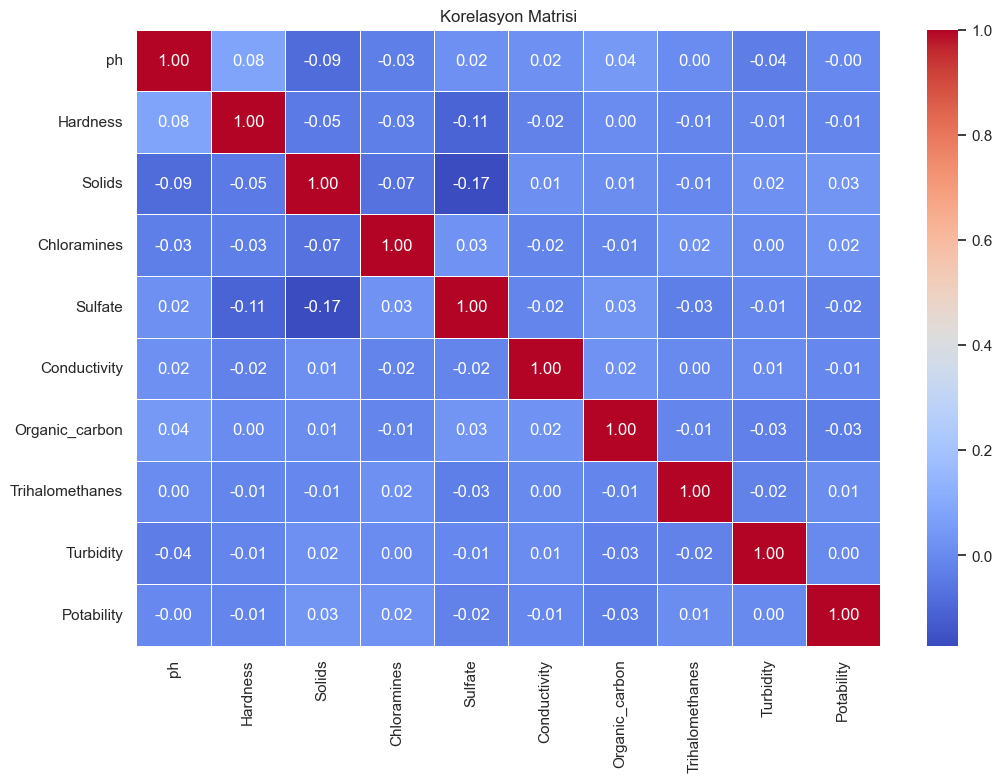

In [165]:
# VERİ SETİ GÖRSELLEŞTİRMESİ 

# KORELASYON MATRİSİ
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()

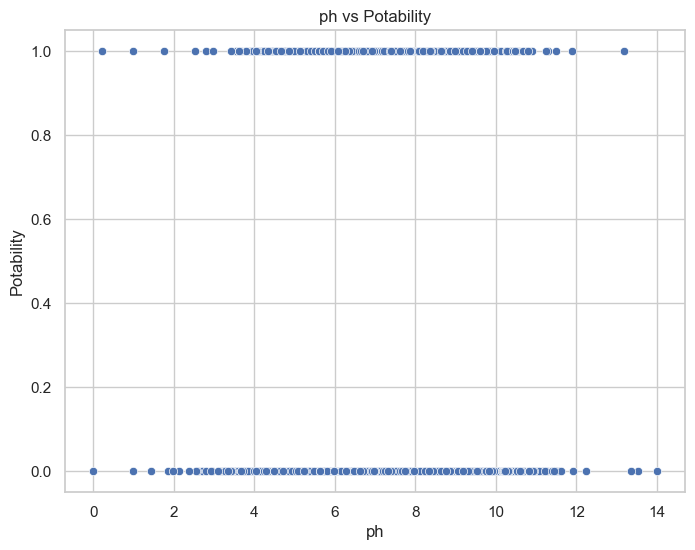

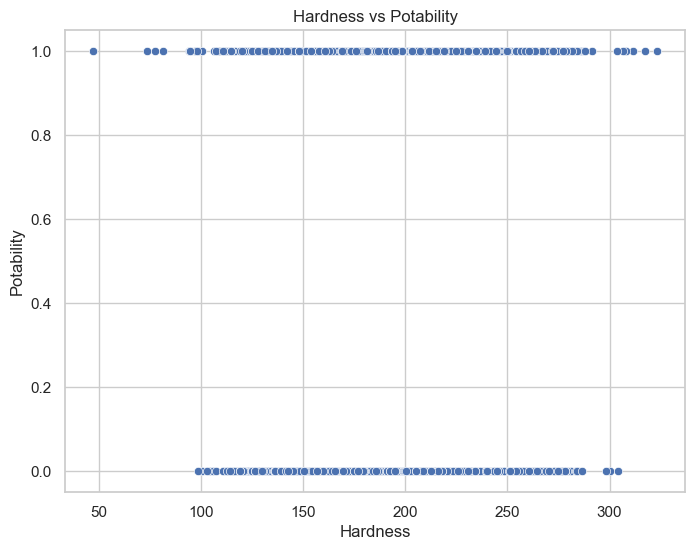

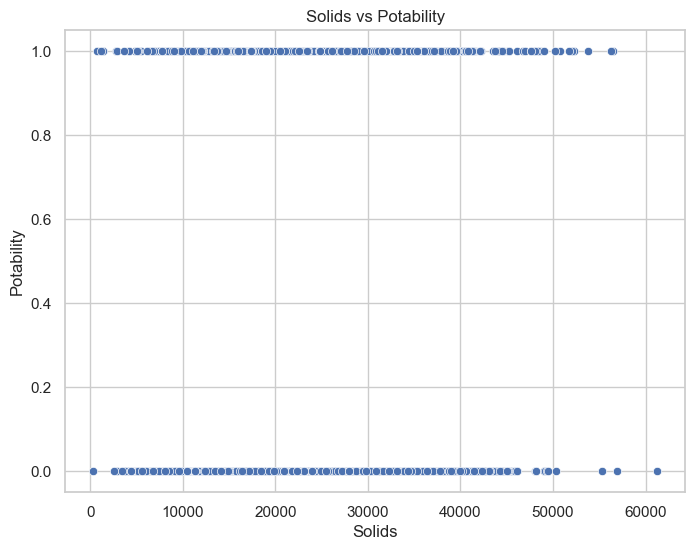

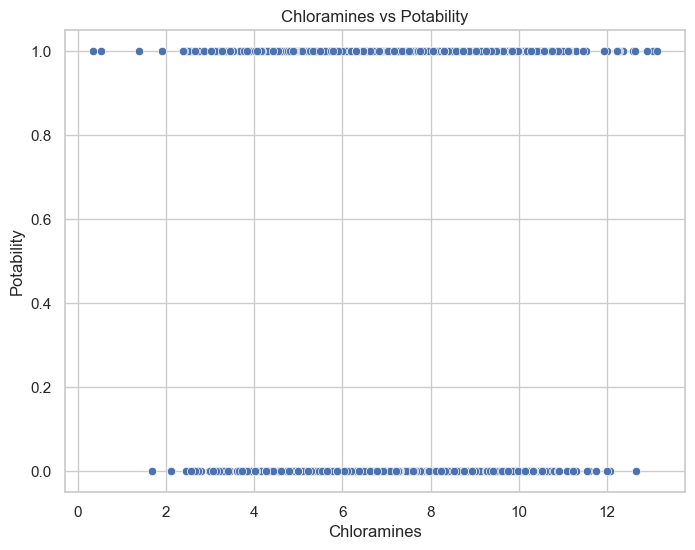

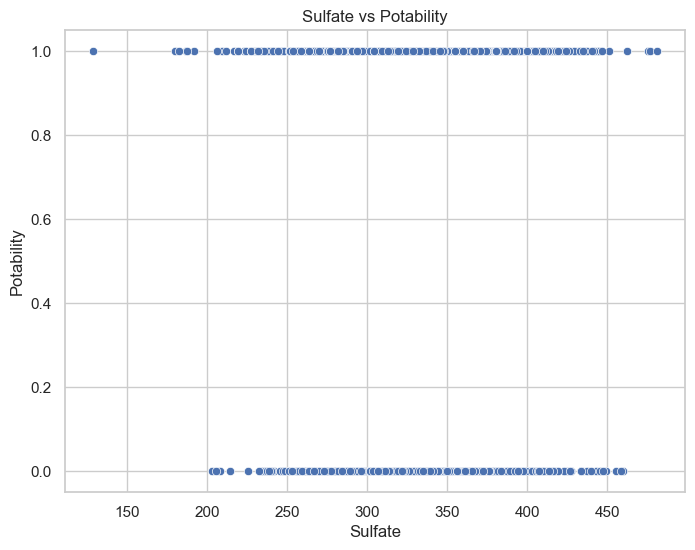

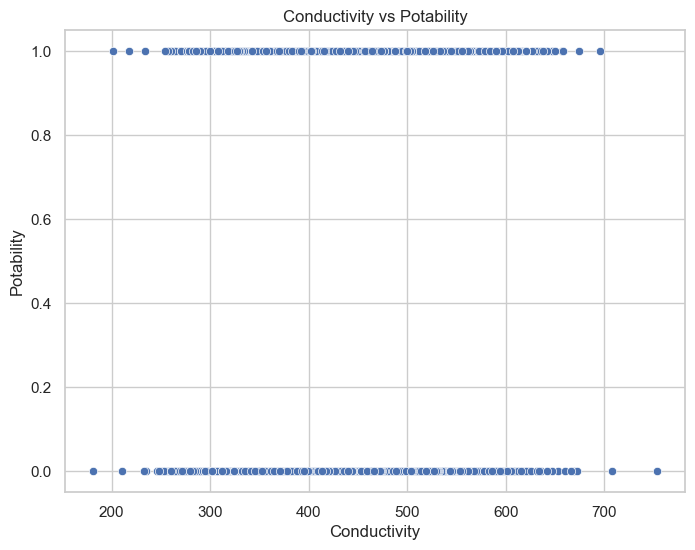

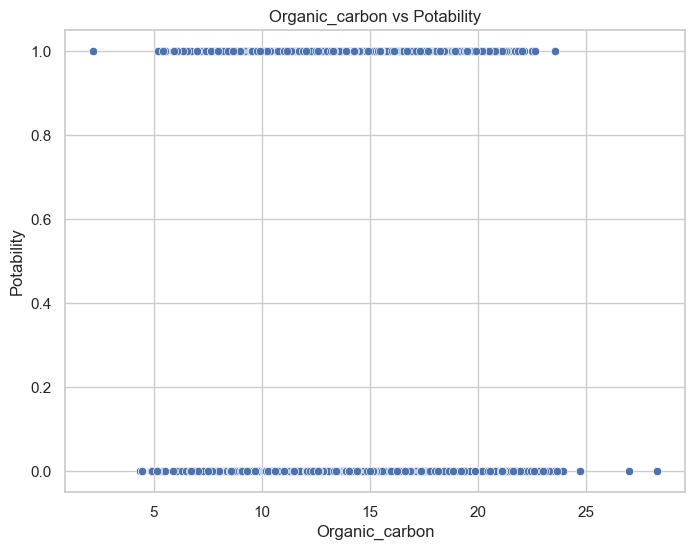

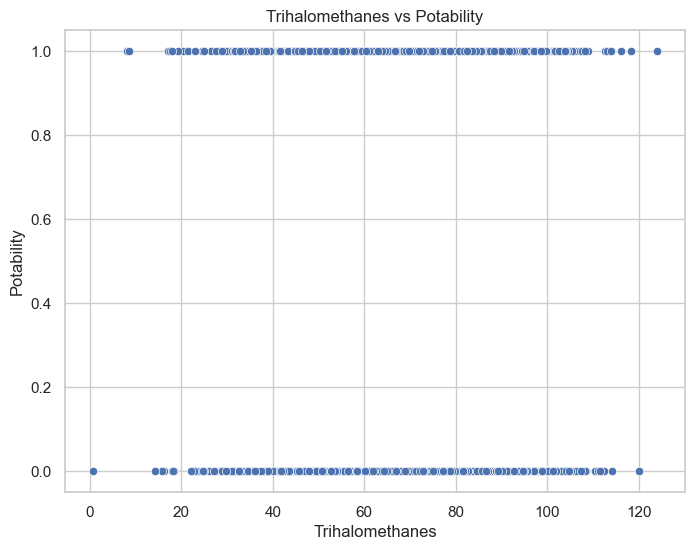

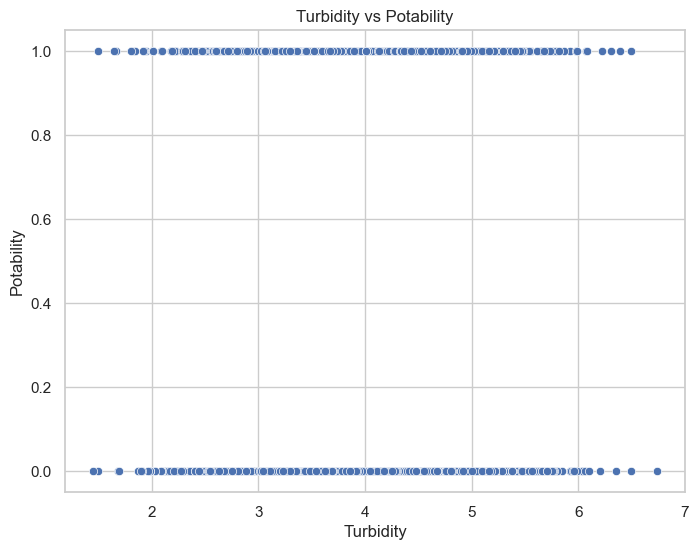

In [167]:
# VERİ SETİ GÖRSELLEŞTİRMESİ 

# SCATTER PLOT (DAĞILIM GRAFİĞİ)

def scatter_plot_df(dataframe):
    dependent_variable = dataframe.columns[-1]
    independent_variables = [col for col in dataframe.columns if col != dependent_variable]
    for feature in independent_variables:
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=dataframe, x= feature, y= dependent_variable)
        plt.title(f"{feature} vs {dependent_variable}")
        plt.show()

scatter_plot_df(df)



In [168]:
# VERİ SETİNİN LİNEER OLMA/OLMAMA DURUMUNU KONTROL ETME

# PEARSON KORELASYONU

def pearson_corr(dataframe):
    dependent_variable = dataframe.columns[-1]
    independent_variables = [col for col in dataframe.columns if col != dependent_variable]
    for feature in independent_variables:
        temp_df = dataframe[[feature, dependent_variable]].dropna()

        if len(temp_df) > 1:
            r, p_value = pearsonr(temp_df[feature], temp_df[dependent_variable])
            print(f"{feature} vs {dependent_variable}: r={r:.4f}, p={p_value:.4f}")
        else:
            print(f"{feature} ve {dependent_variable} arasında yeterli veri yok.")

pearson_corr(df)

# r değeri, -1 ile +1 arasında bir değer alır.
#   r, +1 e yaklaştıkça güçlü pozitif lineer ilişki
#   r, -1 e yaklaştıkça güçlü negatif lineer ilişki
#   r, 0 a yaklaştıkça ilişki zayıf veya yok

ph vs Potability: r=-0.0036, p=0.8512
Hardness vs Potability: r=-0.0138, p=0.4285
Solids vs Potability: r=0.0337, p=0.0535
Chloramines vs Potability: r=0.0238, p=0.1736
Sulfate vs Potability: r=-0.0236, p=0.2391
Conductivity vs Potability: r=-0.0081, p=0.6419
Organic_carbon vs Potability: r=-0.0300, p=0.0860
Trihalomethanes vs Potability: r=0.0071, p=0.6908
Turbidity vs Potability: r=0.0016, p=0.9279


In [169]:
# VERİ ÖN İŞLEME AŞAMASI - PREPROCESSING 

# Eksik Değerlerin Tespiti
def missing_values_table(dataframe, missing_name=False):
    missing_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    number_of_missing_values = dataframe[missing_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[missing_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([number_of_missing_values, np.round(ratio, 2)], axis=1, keys=["Eksik Değerler", "Oran"])
    print(missing_df, end="\n")
    if missing_name:
        return missing_columns

missing_values_table(df)

# Eksik Verilerin Doldurulması
filled_df = df.apply(lambda x: x.fillna(x.mean() if x.dtype != 'O' else x), axis=0)
filled_df

                 Eksik Değerler   Oran
Sulfate                     781  23.84
ph                          491  14.99
Trihalomethanes             162   4.95


ph    Hardness        Solids  Chloramines     Sulfate  \
0     7.080795  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246  333.775777   
2     8.099124  224.236259  19909.541732     9.275884  333.775777   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362  333.775777   
3273  9.419510  175.762646  33155.578218     7.350233  333.775777   
3274  5.126763  230.603758  11983.869376     6.303357  333.775777   
3275  7.874671  195.102299  17404.177061     7.509306  333.775777   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1       592.885359       15.180013        56.329076   4.500656           0  
2       418.606213       16.868637        66.420093   3.055934           0  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
...            ...             ...              ...        ...         ...  
3271    526.424171       13.894419        66.687695   4.435821           1  
3272    392.449580       19.903225        66.396293   2.798243           1  
3273    432.044783       11.039070        69.845400   3.298875           1  
3274    402.883113       11.168946        77.488213   4.708658           1  
3275    327.459760       16.140368        78.698446   2.309149           1  

[3276 rows x 10 columns]

In [170]:
# VERİ ÖN İŞLEME AŞAMASI - PREPROCESSING 

# Outlier Tespiti
def outlier_tresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    iqr_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr_range
    low_limit = quartile1 - 1.5 * iqr_range
    return low_limit, up_limit
    
def outlier_check(dataframe, col_name):
    low_limit, up_limit = outlier_tresholds(dataframe, col_name)
    if df[(dataframe[col_name]< low_limit) | (dataframe[col_name] > up_limit)].any(axis=None):
        return True
    else:
        return False

# Öncesi
for col in filled_df.columns:
    outlier_check(filled_df, col)
    print("(Öncesi)", col, outlier_check(filled_df, col))

# Outlier Değerlerini Ortamala İle Doldurma

def outlier_doldurma(dataframe, col_name):
    low_limit, up_limit = outlier_tresholds(dataframe, col_name)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

# Sonrası
for col in filled_df.columns:
   outlier_doldurma(filled_df, col)

print("\n")

for col in filled_df.columns:
    print("(Sonrası)", col, outlier_check(filled_df, col))


(Öncesi) ph True
(Öncesi) Hardness True
(Öncesi) Solids True
(Öncesi) Chloramines True
(Öncesi) Sulfate True
(Öncesi) Conductivity True
(Öncesi) Organic_carbon True
(Öncesi) Trihalomethanes True
(Öncesi) Turbidity True
(Öncesi) Potability False


(Sonrası) ph False
(Sonrası) Hardness False
(Sonrası) Solids False
(Sonrası) Chloramines False
(Sonrası) Sulfate False
(Sonrası) Conductivity False
(Sonrası) Organic_carbon False
(Sonrası) Trihalomethanes False
(Sonrası) Turbidity False
(Sonrası) Potability False


In [171]:
# VERİ ÖN İŞLEME AŞAMASI - PREPROCESSING 

# Veri Seti Dengesini Kontrol Etme

class_count = df['Potability'].value_counts()
print(class_count)

class_ratios = df['Potability'].value_counts(normalize=True)
print(class_ratios)

# SMOTE Yöntemiyle Veri Setinin Dengelenmesi
col_name = filled_df.columns[-1]
df_smote = filled_df.drop(columns=[col_name])
print(df_smote)
target_name = filled_df[col_name]
print(target_name)
smote = SMOTE(random_state=42)
data_resampled, target_name_resampled = smote.fit_resample(df_smote, target_name)
balanced_df = pd.concat([data_resampled, target_name_resampled], axis=1)

print("Önce:", Counter(target_name))
print("Sonra", Counter(target_name_resampled))

Potability
0    1998
1    1278
Name: count, dtype: int64
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
            ph    Hardness        Solids  Chloramines     Sulfate  \
0     7.080795  204.890455  20791.318981     7.300212  368.516441   
1     3.889107  129.422921  18630.057858     6.635246  333.775777   
2     8.099124  224.236259  19909.541732     9.275884  333.775777   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  44831.869873     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362  333.775777   
3273  9.419510  175.762646  33155.578218     7.350233  333.775777   
3274  5.126763  230.603758  11983.869376     6.303357  333.775777   
3275  7.874671  195.102299  17404.177061     7.509306  333.775777   

      Conductivity  Organic_carbon  Trihalom

In [172]:
# VERİ ÖN İŞLEME AŞAMASI - PREPROCESSING 

# Normalizasyon
mm_scaler = MinMaxScaler()
normalized_data = mm_scaler.fit_transform(filled_df) # Son hal - no missing value, no outlier, balanced
print(normalized_data)

# Standardizasyon
s_scaler = StandardScaler()
standardized_data = s_scaler.fit_transform(filled_df) # Son hal - no missing value, no outlier, balanced
print(standardized_data)

[[0.50108852 0.5510553  0.45989553 ... 0.75393233 0.26266465 0.        ]
 [0.         0.07721441 0.41133978 ... 0.37102153 0.62507931 0.        ]
 [0.66096422 0.67252253 0.44008517 ... 0.49703981 0.28453849 0.        ]
 ...
 [0.86826219 0.36816941 0.73767584 ... 0.53981561 0.34180318 1.        ]
 [0.19430949 0.71250239 0.2620239  ... 0.63526032 0.67410827 1.        ]
 [0.62572558 0.48959802 0.38379866 ... 0.65037392 0.10851115 1.        ]]
[[ 6.12122530e-04  2.65461463e-01 -1.35691325e-01 ...  1.32843613e+00
  -1.29265686e+00 -7.99774743e-01]
 [-2.30929249e+00 -2.09199269e+00 -3.87249133e-01 ... -6.51694738e-01
   6.87944100e-01 -7.99774743e-01]
 [ 7.37602948e-01  8.69785504e-01 -2.38324899e-01 ... -2.16021711e-05
  -1.17311602e+00 -7.99774743e-01]
 ...
 [ 1.69319962e+00 -6.44432768e-01  1.30343415e+00 ...  2.21183182e-01
  -8.60163745e-01  1.25035206e+00]
 [-1.41356972e+00  1.06869335e+00 -1.16082554e+00 ...  7.14752479e-01
   9.55887998e-01  1.25035206e+00]
 [ 5.75160784e-01 -4.03008

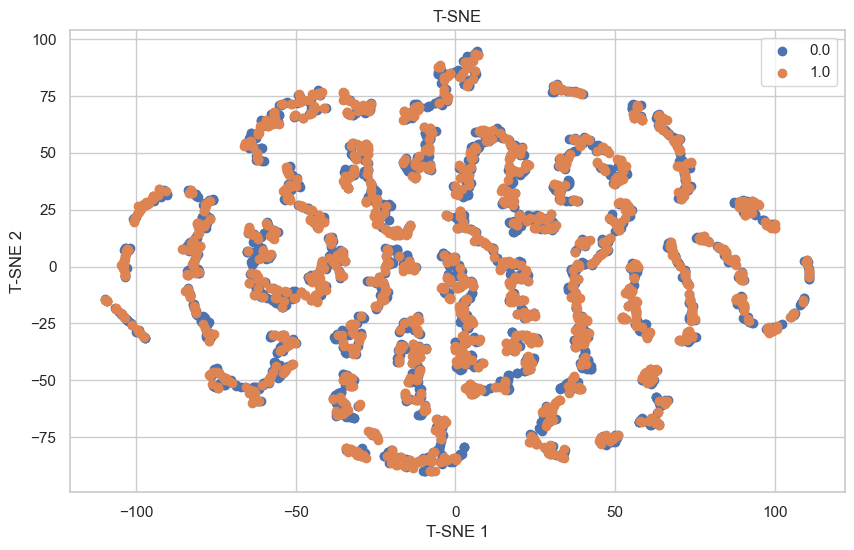

In [173]:
# FEATURE EXTRACTION - NON-LINEAR

# t-SNE with data that after SMOTE
X_tsne_new = data_resampled
y_tsne = target_name_resampled

tsne = TSNE(n_components=2, random_state=0, perplexity=10)
X_tsne = tsne.fit_transform(X_tsne_new)

plt.figure(figsize=(10,6))
targets = list(target_name_resampled.unique())
for i in np.unique(y_tsne):
    i_int = int(i)
    plt.scatter(X_tsne[y_tsne == i, 0],
                X_tsne[y_tsne == i, 1],
                label= targets[i_int])

plt.xlabel("T-SNE 1")
plt.ylabel("T-SNE 2")
plt.title("T-SNE")
plt.legend()
plt.show()

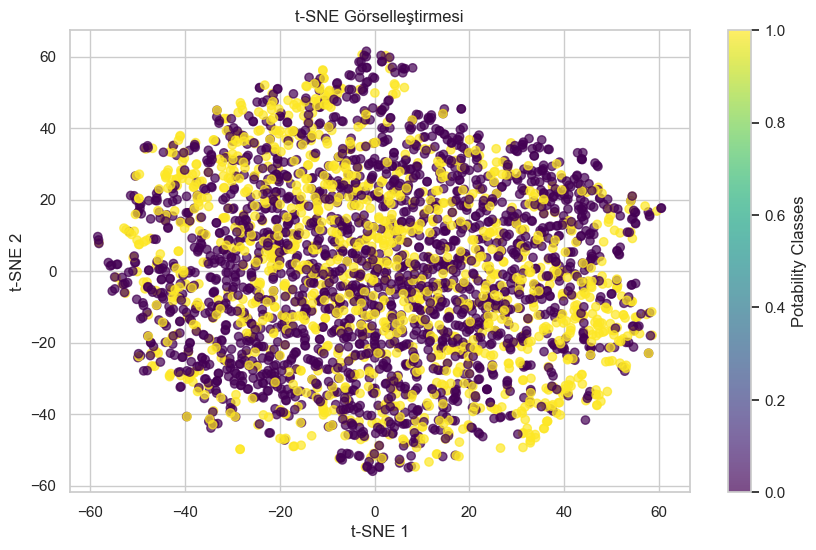

In [174]:
# FEATURE EXTRACTION - NON-LINEAR

# t-SNE with normalized X 
X = filled_df.drop('Potability', axis=1)
y = filled_df['Potability']

X_norm = mm_scaler.fit_transform(X)  # X'i yeniden normalleştirme

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_stand)

# X_tsne bir numpy array'dir. shape: (n_samples, 2)
plt.figure(figsize=(10, 6))
# Burada renkleri hedef değişkenine göre ayarlıyoruz.
# c parametresi, hangi renge boyanacağını belirler. y'den 0 ve 1 değerlerini alır.
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Potability Classes')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Görselleştirmesi")
plt.show()

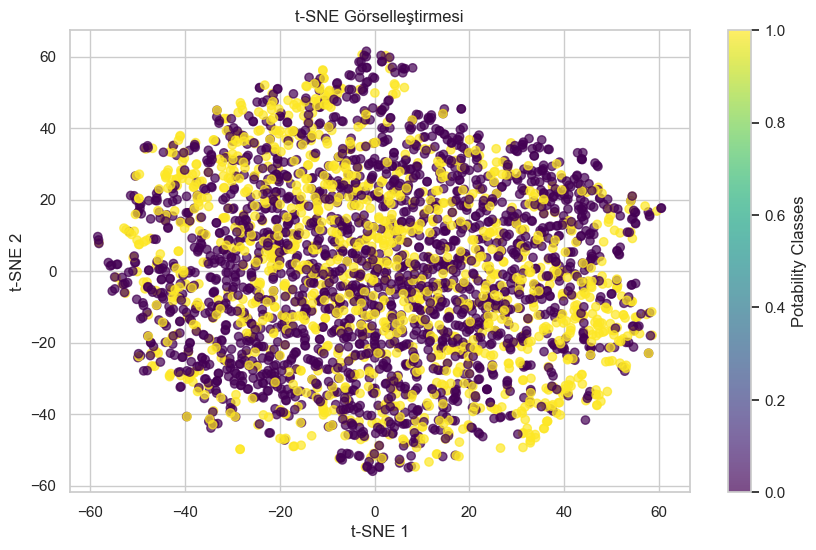

In [175]:
# FEATURE EXTRACTION - NON-LINEAR

# t-SNE with standardized X 
X = filled_df.drop('Potability', axis=1)
y = filled_df['Potability']

X_stand = s_scaler.fit_transform(X) # X'i yeniden standartlaştırma

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_stand)

# X_tsne bir numpy array'dir. shape: (n_samples, 2)
plt.figure(figsize=(10, 6))
# Burada renkleri hedef değişkenine göre ayarlıyoruz.
# c parametresi, hangi renge boyanacağını belirler. y'den 0 ve 1 değerlerini alır.
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Potability Classes')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Görselleştirmesi")
plt.show()

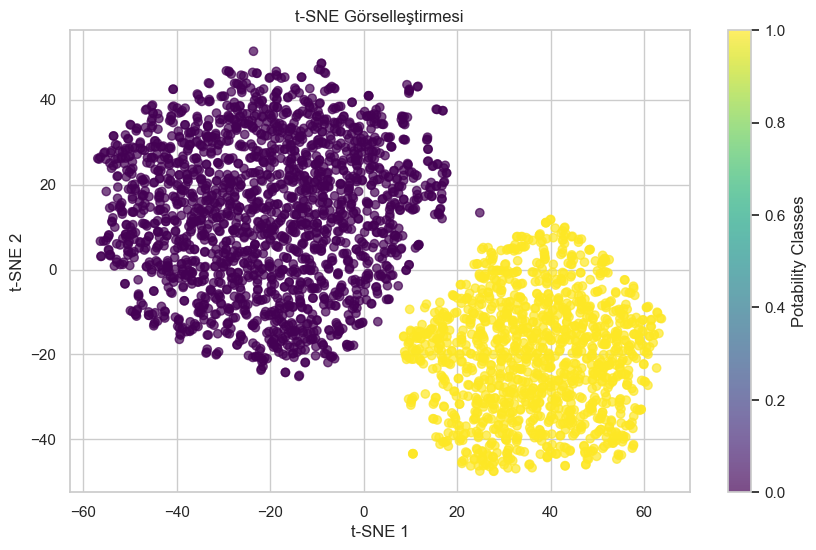

In [176]:
# FEATURE EXTRACTION - NON-LINEAR

# t-SNE with standardized_data
X = standardized_data
y = filled_df['Potability']

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# X_tsne bir numpy array'dir. shape: (n_samples, 2)
plt.figure(figsize=(10, 6))
# Burada renkleri hedef değişkenine göre ayarlıyoruz.
# c parametresi, hangi renge boyanacağını belirler. y'den 0 ve 1 değerlerini alır.
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Potability Classes')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Görselleştirmesi")
plt.show()

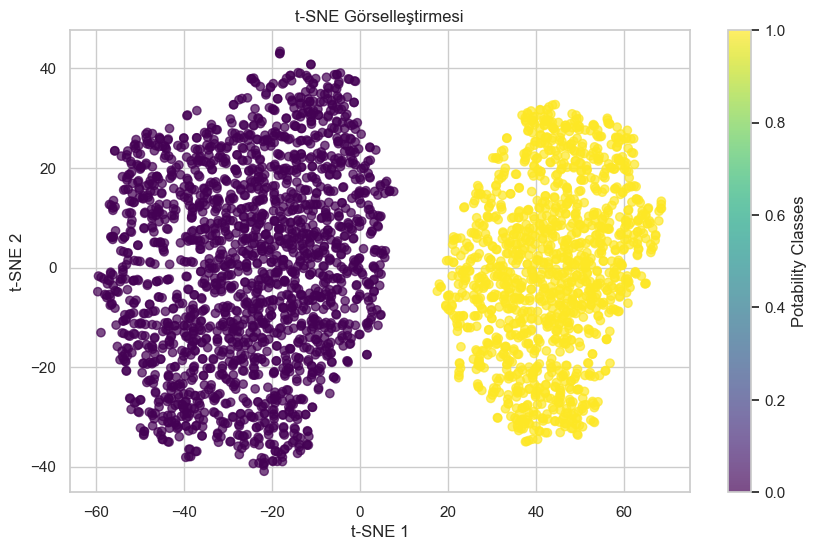

In [178]:
# FEATURE EXTRACTION - NON-LINEAR

# t-SNE with normalized_data
X = normalized_data
y = filled_df['Potability']

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# X_tsne bir numpy array'dir. shape: (n_samples, 2)
plt.figure(figsize=(10, 6))
# Burada renkleri hedef değişkenine göre ayarlıyoruz.
# c parametresi, hangi renge boyanacağını belirler. y'den 0 ve 1 değerlerini alır.
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Potability Classes')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Görselleştirmesi")
plt.show()

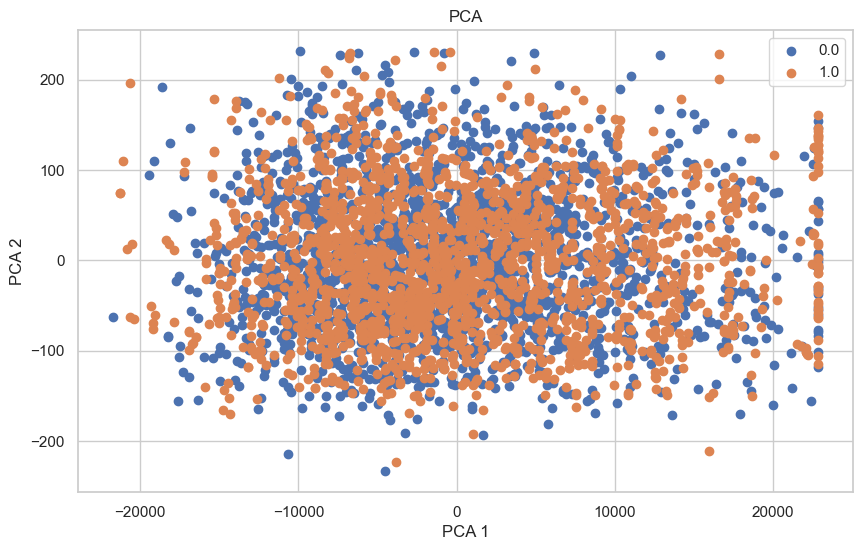

In [180]:
# FEATURE EXTRACTION - LINEAR

# PCA - Principal Component Analysis with data that after SMOTE
X = data_resampled
y = target_name_resampled

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
targets = list(target_name_resampled.unique())
for i in range(len(targets)):
    plt.scatter(X_pca[y == i, 0],
                X_pca[y == i, 1],
                label= targets[i])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA")
plt.legend()
plt.show()

Açıklanan Varyans Oranları (Explained Variance Ratio): [0.13285846 0.12648222]
Toplam açıklanan varyans: 0.2593406874862402


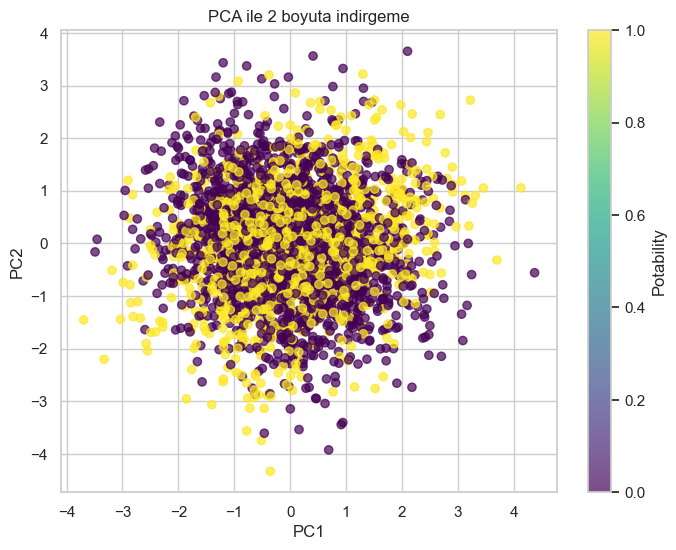

In [181]:
# FEATURE EXTRACTION - LINEAR

# PCA - Principal Component Analysis with standardization
X = filled_df.drop('Potability', axis=1)
y = filled_df['Potability']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Açıklanan Varyans Oranları (Explained Variance Ratio):", pca.explained_variance_ratio_)
print("Toplam açıklanan varyans:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Potability')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA ile 2 boyuta indirgeme')
plt.show()

Açıklanan Varyans Oranları (Explained Variance Ratio): [0.16886192 0.14199138]
Toplam açıklanan varyans: 0.31085329892154123


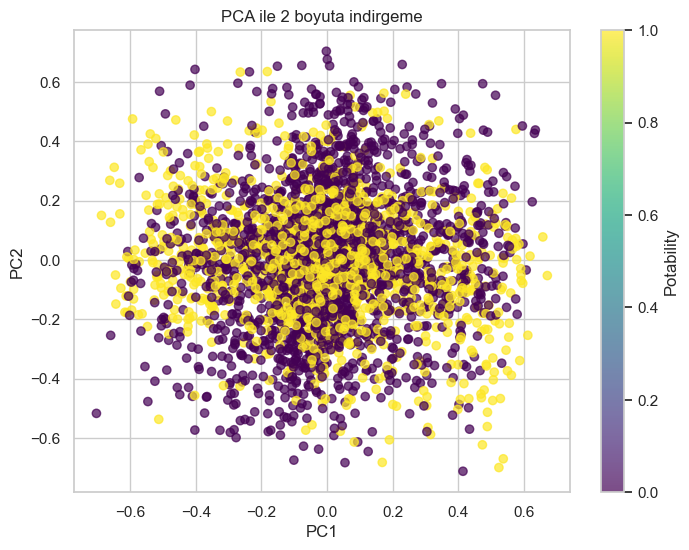

In [182]:
# FEATURE EXTRACTION - LINEAR

# PCA - Principal Component Analysis with normalization
X = filled_df.drop('Potability', axis=1)
y = filled_df['Potability']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Açıklanan Varyans Oranları (Explained Variance Ratio):", pca.explained_variance_ratio_)
print("Toplam açıklanan varyans:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Potability')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA ile 2 boyuta indirgeme')
plt.show()

Açıklanan Varyans Oranları (Explained Variance Ratio): [0.12004068 0.1140273 ]
Toplam açıklanan varyans: 0.23406797685075215


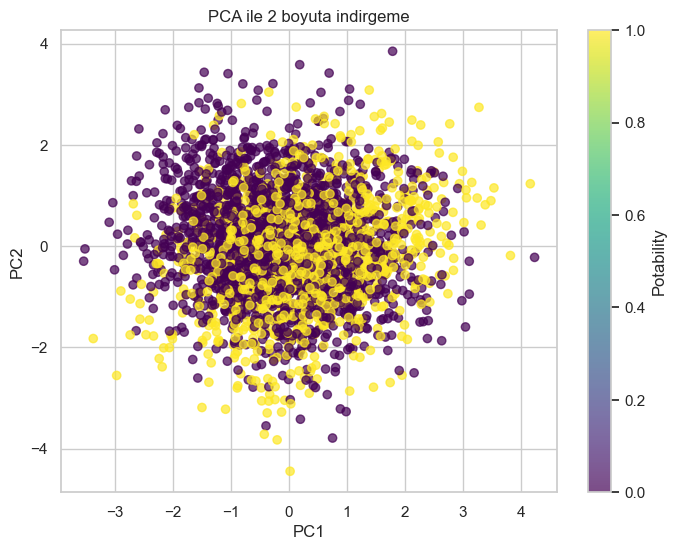

In [183]:
# FEATURE EXTRACTION - LINEAR

# PCA - Principal Component Analysis with standardized_data
X = standardized_data
y = filled_df['Potability']

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print("Açıklanan Varyans Oranları (Explained Variance Ratio):", pca.explained_variance_ratio_)
print("Toplam açıklanan varyans:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Potability')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA ile 2 boyuta indirgeme')
plt.show()

Açıklanan Varyans Oranları (Explained Variance Ratio): [0.40231971 0.10091237]
Toplam açıklanan varyans: 0.5032320717404378


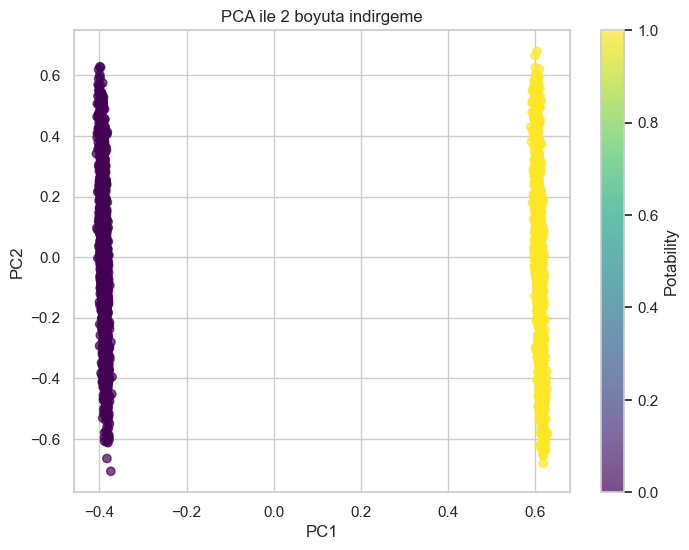

In [190]:
# FEATURE EXTRACTION - LINEAR

# PCA - Principal Component Analysis with normalized_data
X = normalized_data
y = filled_df['Potability']

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print("Açıklanan Varyans Oranları (Explained Variance Ratio):", pca.explained_variance_ratio_)
print("Toplam açıklanan varyans:", sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Potability')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA ile 2 boyuta indirgeme')
plt.show()

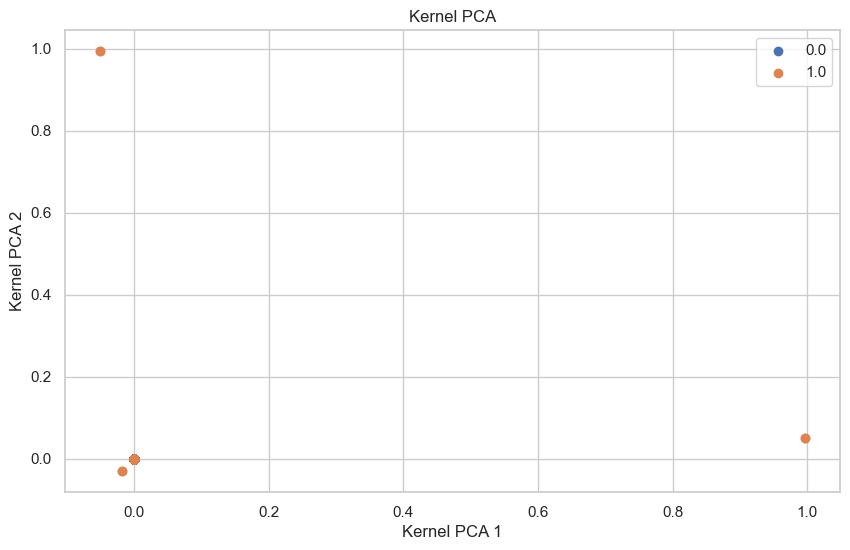

In [191]:
# FEATURE EXTRACTION - NON-LINEAR

# KERNEL PCA with data that after SMOTE
X_kpca_new = data_resampled
y_kpca = target_name_resampled

kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X_kpca_new)

plt.figure(figsize=(10, 6))
targets = list(target_name_resampled.unique())
for i in np.unique(y_kpca):
    i_int = int(i)
    plt.scatter(X_kpca[y_kpca == i, 0],
                X_kpca[y_kpca == i, 1],
                label= targets[i_int])
    
plt.xlabel("Kernel PCA 1")
plt.ylabel("Kernel PCA 2")
plt.title("Kernel PCA")
plt.legend()
plt.show()

X_kpca shape: (3276, 2)


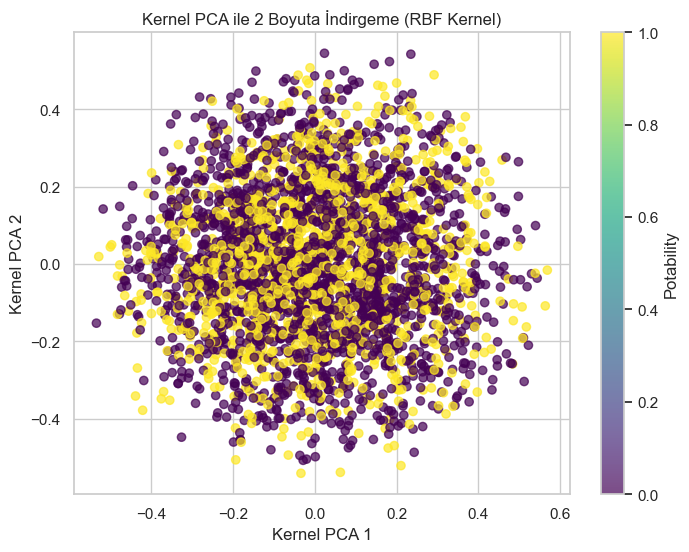

In [192]:
# FEATURE EXTRACTION - NON-LINEAR

# Kernel PCA with standardization 
X = filled_df.drop('Potability', axis=1)
y = filled_df['Potability']

# Veriyi ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Kernel PCA nesnesi oluşturma:
# Burada RBF (Gaussian) kernel kullanılıyor. 
# gamma parametresi verinin dağılımına göre ayarlanabilir.
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, random_state=42)

# Dönüşümü uygula
X_kpca = kpca.fit_transform(X_scaled)

# Çıktının boyutu (n_samples, 2) olacak
print("X_kpca shape:", X_kpca.shape)

# Görselleştirme:
plt.figure(figsize=(8,6))
plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Potability')
plt.xlabel('Kernel PCA 1')
plt.ylabel('Kernel PCA 2')
plt.title('Kernel PCA ile 2 Boyuta İndirgeme (RBF Kernel)')
plt.show()

X_kpca shape: (3276, 2)


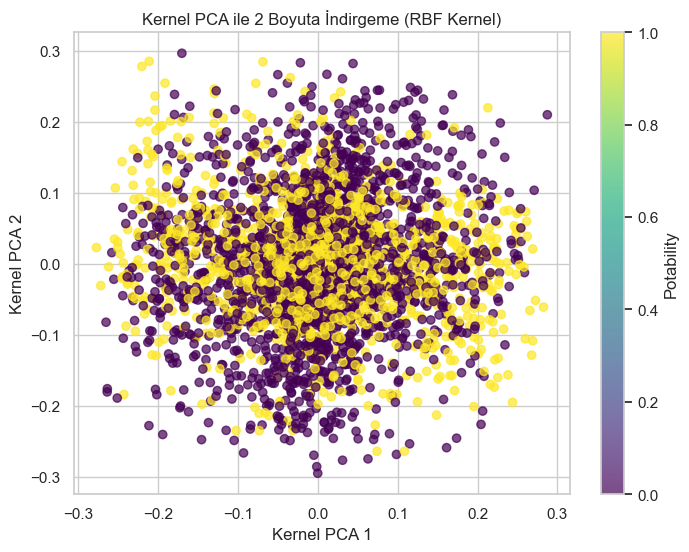

In [193]:
# FEATURE EXTRACTION - NON-LINEAR

# Kernel PCA with normalization 
X = filled_df.drop('Potability', axis=1)
y = filled_df['Potability']

# Veriyi ölçeklendirme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Kernel PCA nesnesi oluşturma:
# Burada RBF (Gaussian) kernel kullanılıyor. 
# gamma parametresi verinin dağılımına göre ayarlanabilir.
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, random_state=42)

# Dönüşümü uygula
X_kpca = kpca.fit_transform(X_scaled)

# Çıktının boyutu (n_samples, 2) olacak
print("X_kpca shape:", X_kpca.shape)

# Görselleştirme:
plt.figure(figsize=(8,6))
plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Potability')
plt.xlabel('Kernel PCA 1')
plt.ylabel('Kernel PCA 2')
plt.title('Kernel PCA ile 2 Boyuta İndirgeme (RBF Kernel)')
plt.show()

X_kpca shape: (3276, 2)


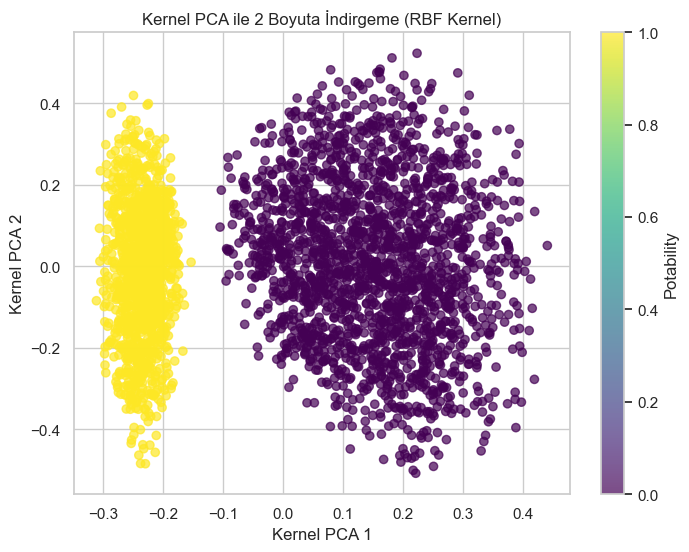

In [194]:
# FEATURE EXTRACTION - NON-LINEAR

# Kernel PCA with stardardized_data
X = standardized_data
y = filled_df['Potability']

# Kernel PCA nesnesi oluşturma:
# Burada RBF (Gaussian) kernel kullanılıyor. 
# gamma parametresi verinin dağılımına göre ayarlanabilir.
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, random_state=42)

# Dönüşümü uygula
X_kpca = kpca.fit_transform(X)

# Çıktının boyutu (n_samples, 2) olacak
print("X_kpca shape:", X_kpca.shape)

# Görselleştirme:
plt.figure(figsize=(8,6))
plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Potability')
plt.xlabel('Kernel PCA 1')
plt.ylabel('Kernel PCA 2')
plt.title('Kernel PCA ile 2 Boyuta İndirgeme (RBF Kernel)')
plt.show()

X_kpca shape: (3276, 2)


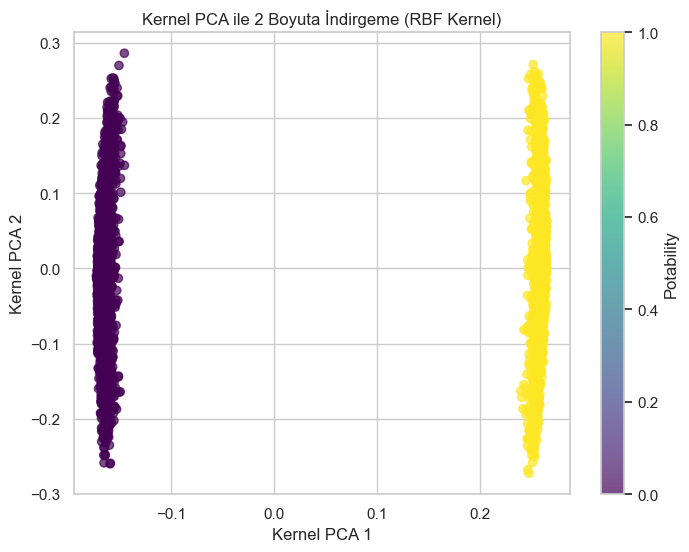

In [195]:
# FEATURE EXTRACTION - NON-LINEAR

# Kernel PCA with normalized_data
X = normalized_data
y = filled_df['Potability']

# Kernel PCA nesnesi oluşturma:
# Burada RBF (Gaussian) kernel kullanılıyor. 
# gamma parametresi verinin dağılımına göre ayarlanabilir.
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, random_state=42)

# Dönüşümü uygula
X_kpca = kpca.fit_transform(X)

# Çıktının boyutu (n_samples, 2) olacak
print("X_kpca shape:", X_kpca.shape)

# Görselleştirme:
plt.figure(figsize=(8,6))
plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(label='Potability')
plt.xlabel('Kernel PCA 1')
plt.ylabel('Kernel PCA 2')
plt.title('Kernel PCA ile 2 Boyuta İndirgeme (RBF Kernel)')
plt.show()

In [196]:
# HOLD-OUT YÖNTEMİYLE VERİ SETİNİ AYIRMA

# FOR T-SNE

X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)
